# 1.1

In [178]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image

# Global settings
dataset_dir = 'dataset'  # Update with your actual path
image_size = (32, 32)  # Update to desired resolution

## Loading Images

First of all, we have to create our (n,x,y,3) array containing all data. In our case, the size of it is (25,32,32,3). We also load the labels, but those will not be neccessary for any calculation whatsoever. 

In [179]:
def load_images_pillow(dataset_dir, image_size=(32, 32)):
    images = []
    labels = []
    categories = os.listdir(dataset_dir)
    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        if os.path.isdir(category_path):
            for file_name in os.listdir(category_path):
                img_path = os.path.join(category_path, file_name)
                try:
                    with Image.open(img_path) as img:
                        img = img.convert('RGB')
                        img = img.resize(image_size)
                        img_array = np.array(img)
                        images.append(img_array)
                        labels.append(category)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

images_array, labels_array = load_images_pillow(dataset_dir, image_size=(32, 32))
print(f"Loaded {images_array.shape[0]} images with labels {set(labels_array)}")

Loaded 25 images with labels {np.str_('dogs'), np.str_('cars'), np.str_('apples'), np.str_('cats'), np.str_('frogs')}


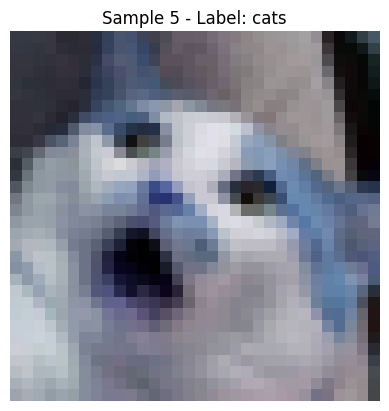

In [180]:
def PlotSample(index):
    plt.imshow(cv2.cvtColor(images_array[index], cv2.COLOR_BGR2RGB))
    plt.title(f"Sample {index} - Label: {labels_array[index]}")
    plt.axis('off')
    plt.show()

PlotSample(5)

# Test the function
# i=0
# while i<25:
#     PlotSample(i)
#     i=i+1

## Flattening the image

Note how we reshape the images from the array. Here, each image is a row, where all pixels are flattened. From the print below, we see that we have our total images (25) and the total size of our 1D vector (3072 pixels). We will read this by the fact that each row is one image, and each column represents a pixel in each image. As for the reason why the size of each row is 3072, it's because of the fact that we are including 3 colour types, and the size of each image is 32x32. By doing the math, we get: 3x32x32=3072 pixels.

In [181]:
flattened_images = images_array.reshape(images_array.shape[0], -1)
#flattened_images = images_array.reshape(-1,3)

print(f"Flattened images shape: {flattened_images.shape}")

Flattened images shape: (25, 3072)


I want to note that we are representing each image by row. We can represent this differently by using the commented line, where we would combine all images by column, and instead divide them for each colour (3). This could be useful for tasks like clustering similar pixel colours or analyzing the general colour distribution in the dataset.

I also want to note that the original whitening function given by the article does not work with the flattening I'm using as of now (25, 3072), but it works for the pixel colour distribution which is given by the commented line, resulting in the shape (25600,3).

## Visualize data and calculate covariance

The code for plotDataAndCov is taken from https://hadrienj.github.io/posts/Preprocessing-for-deep-learning/ which is given by the instructions.

Covariance matrix:
 [[8051.84   7584.984  7988.288  ... 5340.232  5191.488  6062.64  ]
 [7584.984  7338.9856 7661.1552 ... 5010.3328 5019.8832 5768.504 ]
 [7988.288  7661.1552 8627.0784 ... 5339.6976 5165.6944 6383.128 ]
 ...
 [5340.232  5010.3328 5339.6976 ... 5812.0064 5704.0016 6140.112 ]
 [5191.488  5019.8832 5165.6944 ... 5704.0016 5831.4304 6166.528 ]
 [6062.64   5768.504  6383.128  ... 6140.112  6166.528  7149.28  ]]


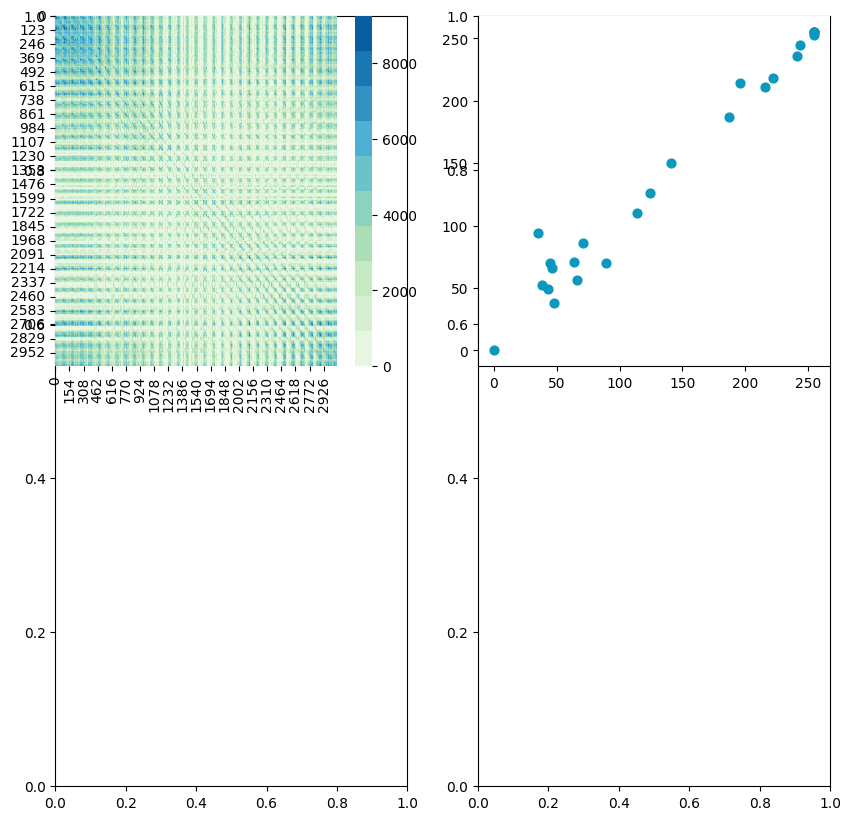

In [182]:
import seaborn as sns

def plotDataAndCov(data):
    ACov = np.cov(data, rowvar=False, bias=True)
    print('Covariance matrix:\n', ACov)

    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(10, 10)

    ax0 = plt.subplot(2, 2, 1)

    # Choosing the colorus
    cmap = sns.color_palette("GnBu", 10)
    sns.heatmap(ACov, cmap=cmap, vmin=0)

    ax1 = plt.subplot(2, 2, 2)

    # data can include the colours
    if data.shape[1]==3:
        c=data[:,2]
    else:
        c="#0A98BE"
    ax1.scatter(data[:,0], data[:,1], c=c, s=40)

    # Remove the top and right axes from the data plot
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

# Call with flattened_images
plotDataAndCov(flattened_images)

## Mean normalization

We center the data in order to remove biases, but according to the resulting matrix, it doesn't seem to change. Generally, this is done to help the model learn faster by starting closer to a real/optimal solution.

Before:


Covariance matrix:
 [[8051.84   7584.984  7988.288  ... 5340.232  5191.488  6062.64  ]
 [7584.984  7338.9856 7661.1552 ... 5010.3328 5019.8832 5768.504 ]
 [7988.288  7661.1552 8627.0784 ... 5339.6976 5165.6944 6383.128 ]
 ...
 [5340.232  5010.3328 5339.6976 ... 5812.0064 5704.0016 6140.112 ]
 [5191.488  5019.8832 5165.6944 ... 5704.0016 5831.4304 6166.528 ]
 [6062.64   5768.504  6383.128  ... 6140.112  6166.528  7149.28  ]]


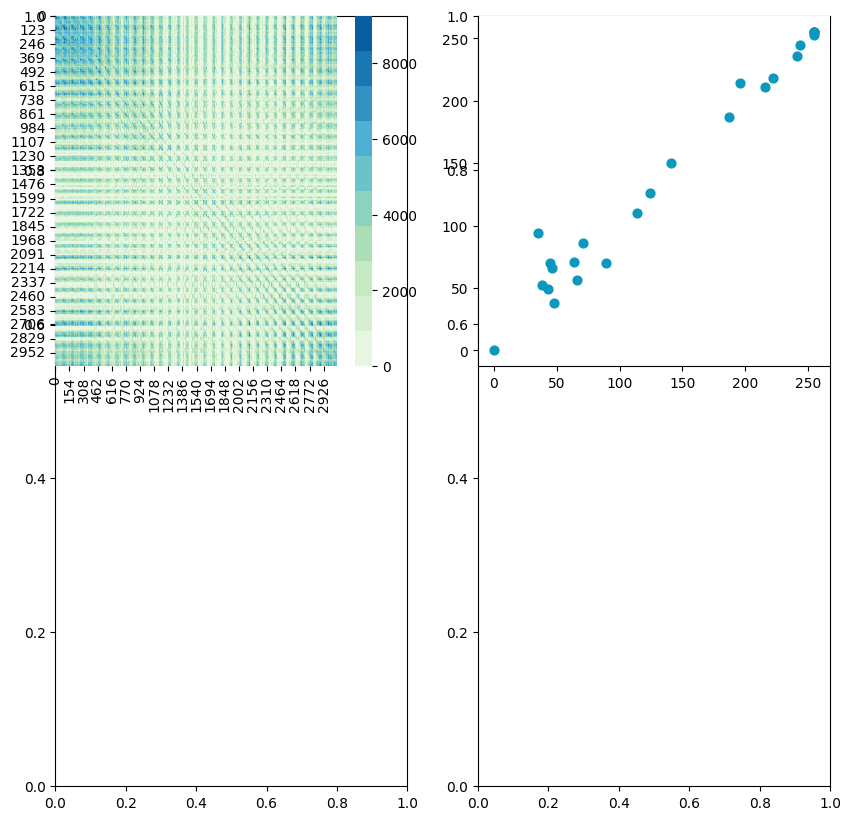

After:


Covariance matrix:
 [[8051.84   7584.984  7988.288  ... 5340.232  5191.488  6062.64  ]
 [7584.984  7338.9856 7661.1552 ... 5010.3328 5019.8832 5768.504 ]
 [7988.288  7661.1552 8627.0784 ... 5339.6976 5165.6944 6383.128 ]
 ...
 [5340.232  5010.3328 5339.6976 ... 5812.0064 5704.0016 6140.112 ]
 [5191.488  5019.8832 5165.6944 ... 5704.0016 5831.4304 6166.528 ]
 [6062.64   5768.504  6383.128  ... 6140.112  6166.528  7149.28  ]]


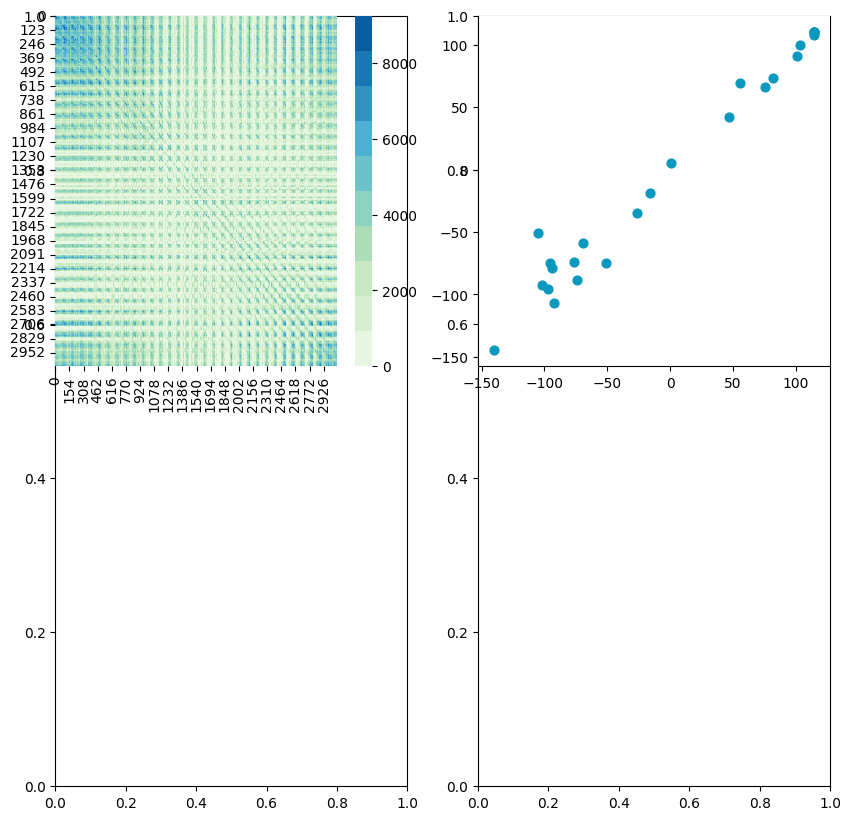

In [183]:
def center(X):
    newX = X - np.mean(X, axis = 0)
    return newX

centeredMatrix = center(flattened_images)

print('Before:\n\n')

plotDataAndCov(flattened_images)
plt.show()
plt.close()

print('After:\n\n')

plotDataAndCov(centeredMatrix)
plt.show()
plt.close()


Since we've printed before and after, we see that there is no visible difference in this case. We note that this is not always the case for all data.

## Standardize

We standardize the data in order to keep our pixels (features) on the same scale, which is important for stability. The result of this processing can be seen both on the axis, but also on the resulting matrix.

Covariance matrix:
 [[1.         0.98670899 0.95846062 ... 0.78063769 0.75762926 0.79906675]
 [0.98670899 1.         0.96281838 ... 0.76715923 0.76734037 0.79636842]
 [0.95846062 0.96281838 1.         ... 0.75408751 0.72829829 0.81277536]
 ...
 [0.78063769 0.76715923 0.75408751 ... 1.         0.97978108 0.95253753]
 [0.75762926 0.76734037 0.72829829 ... 0.97978108 1.         0.95504098]
 [0.79906675 0.79636842 0.81277536 ... 0.95253753 0.95504098 1.        ]]


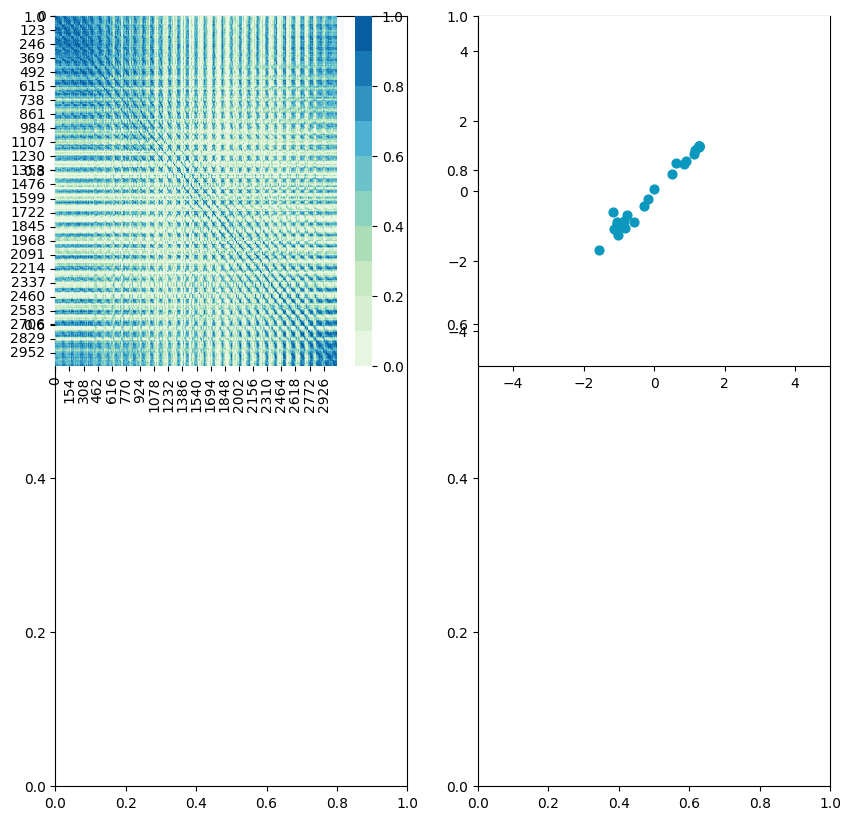

In [184]:
def standardize(X):
    newX = center(X)/np.std(X, axis = 0)
    return newX

#CStandardized = standardize(centeredMatrix)
standardizedMatrix = standardize(flattened_images)


plotDataAndCov(standardizedMatrix)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()
plt.close()


The result is to be expected: both axis follow the same pattern and both are centered around zero! Here we can see a large difference between the regular, flattened array and the resulting covariance matrix.

## Whitening

We are going to use the following steps for our resulting matrix:

1- Zero-center the data
2- Decorrelate the data
3- Rescale the data

## Zero-centering
To start things off, we can zero-center by simply using center(). This will result in our features centering around zero, which is needed for the later steps in the whitening.

## Decorrelating
We decorrelate the features in order to have no correlation between them. This, essentially, means that we rotate our data points.

In [185]:
def decorrelate(X):
    XCentered = center(X)
    cov = XCentered.T.dot(XCentered)/float(XCentered.shape[0])
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigVals, eigVecs = np.linalg.eig(cov)
    # Apply the eigenvectors to X
    decorrelated = X.dot(eigVecs)
    return decorrelated

## Whitening

The given function for whitening looks like this, and was given by the referred article. Note that the steps above are all included in this simple function:

In [186]:
def whiten(X):
    XCentered = center(X)
    cov = XCentered.T.dot(XCentered)/float(XCentered.shape[0])
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigVals, eigVecs = np.linalg.eig(cov)
    # Apply the eigenvectors to X
    decorrelated = X.dot(eigVecs)
    # Rescale the decorrelated data
    whitened = decorrelated / np.sqrt(eigVals + 1e-5)
    return whitened

In [187]:
def plotImage(X):
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(X.reshape(32, 32, 3))
    plt.show()
    plt.close()

## Whitening implementation

Now, since they showed a hands-on implementation of how this would look like with real images, I've implemented the steps taken by creating two functions: zca_whiten and rescale_for_visualization. As can be seen, each step is directly based off of the implementation given in the article.

In [188]:
def zca_whiten(X, epsilon=0.1):
    # Step 1: Normalize the dataset by dividing by 255 to bring values to [0, 1]
    X_norm = X / 255.0
    
    # Step 2: Center the data by subtracting the mean of each feature (pixel position)
    X_centered = X_norm - X_norm.mean(axis=0)
    
    # Step 3: Compute the covariance matrix of the centered data
    cov = np.cov(X_centered, rowvar=False)
    
    # Step 4: Perform Singular Value Decomposition (SVD) on the covariance matrix
    U, S, V = np.linalg.svd(cov)
    
    # Step 5: Construct the ZCA whitening matrix
    zca_matrix = U @ np.diag(1.0 / np.sqrt(S + epsilon)) @ U.T
    
    # Step 6: Apply the ZCA whitening matrix to the centered data
    X_ZCA = X_centered @ zca_matrix
    
    return X_ZCA

def rescale_for_visualization(X):
    return (X - X.min()) / (X.max() - X.min())

And to prove it all works, the results can be seen below. 

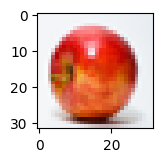

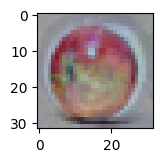

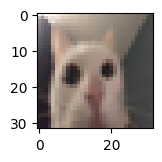

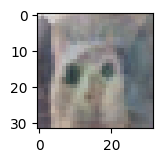

Covariance matrix:
 [[0.01720055 0.01563597 0.01380393 ... 0.00322306 0.00226811 0.00314105]
 [0.01563597 0.01557991 0.01384441 ... 0.00256407 0.00275591 0.00359388]
 [0.01380393 0.01384441 0.01707298 ... 0.00189997 0.00055159 0.00279598]
 ...
 [0.00322306 0.00256407 0.00189997 ... 0.00727874 0.00625121 0.00481009]
 [0.00226811 0.00275591 0.00055159 ... 0.00625121 0.00704641 0.00538677]
 [0.00314105 0.00359388 0.00279598 ... 0.00481009 0.00538677 0.00654999]]


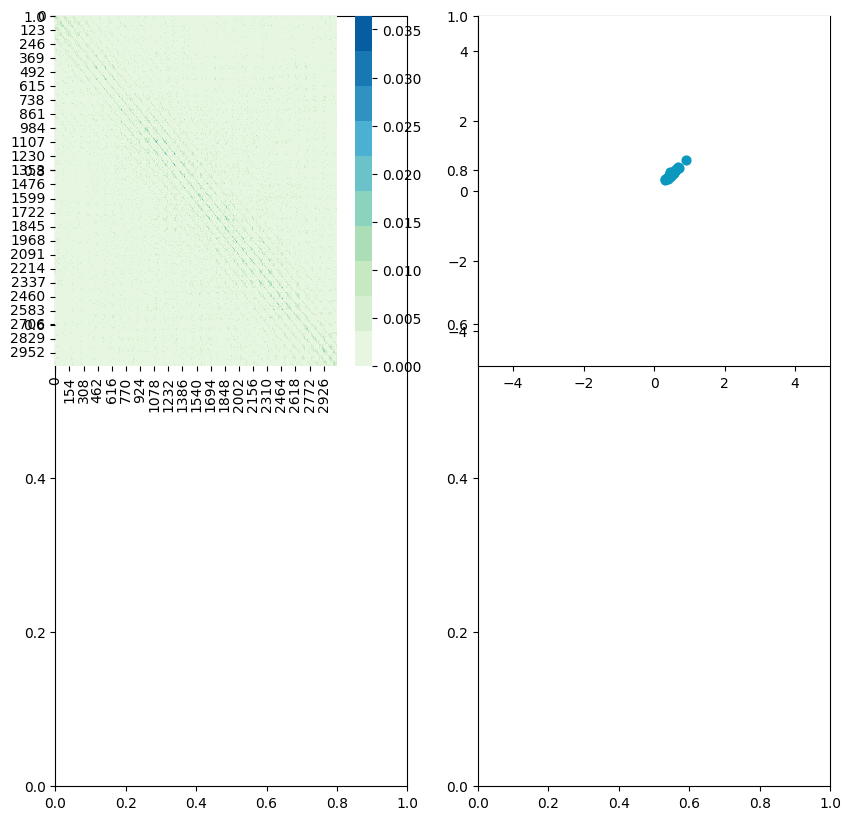

In [189]:
X_ZCA = zca_whiten(flattened_images)
X_ZCA_rescaled = rescale_for_visualization(X_ZCA)

# plotImage(images_array[12])
# plotImage(X_ZCA_rescaled[12, :])

plotImage(flattened_images[12, :])
plotImage(X_ZCA_rescaled[12, :])

plotImage(flattened_images[6])
plotImage(X_ZCA_rescaled[6])

plotDataAndCov(X_ZCA_rescaled)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()
plt.close()

We see that the resulting images are whitened, and by plotting the covariance vectors, it is zero-centered and as decorrelated as it can be.

# 1.2